In [3]:
!pip install imutils

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import random
import cv2

from keras.models import Model,Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,Activation,Input,Flatten,Lambda
from keras.optimizers import SGD,Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split

from imutils import paths,build_montages

sns.set()

Using TensorFlow backend.


In [5]:
imagePaths = sorted(list(paths.list_images('/kaggle/input/apparel-images-dataset')))

In [6]:
random.seed(42)
random.shuffle(imagePaths)

In [7]:
images = []
color_labels = []
cat_labels = []

for i in imagePaths:
    image = cv2.imread(i)
    image = cv2.resize(image , (96,96))
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    images.append(image)
    
    (col,cat) = i.split('/')[-2].split('_')
    color_labels.append(col)
    cat_labels.append(cat)
    
    

In [8]:
images = np.array(images, dtype="float") / 255.0
color_labels = np.array(color_labels)
cat_labels = np.array(cat_labels)

In [9]:
catLB = LabelBinarizer()
colorLB = LabelBinarizer()

In [10]:
catLabels = catLB.fit_transform(cat_labels)
colorLabels = colorLB.fit_transform(color_labels)

In [11]:
split = train_test_split(images,catLabels,colorLabels,test_size=0.2,random_state=42)

In [12]:
(trainX , testX , trainCatY, testCatY , trainColorY , testColorY) = split

In [13]:
print(trainX.shape)
print(type(trainX))
print(testX.shape)
print(type(testX))
print(trainColorY.shape)
print(type(trainColorY))
print(testColorY.shape)
print(type(testColorY))
print(trainCatY.shape)
print(type(trainCatY))
print(testCatY.shape)
print(type(testCatY))

(9108, 96, 96, 3)
<class 'numpy.ndarray'>
(2277, 96, 96, 3)
<class 'numpy.ndarray'>
(9108, 6)
<class 'numpy.ndarray'>
(2277, 6)
<class 'numpy.ndarray'>
(9108, 5)
<class 'numpy.ndarray'>
(2277, 5)
<class 'numpy.ndarray'>


In [14]:
class FashionNet:
    @staticmethod
    def build_category_model(inputs,numCat):
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        
        x = Conv2D(32, (3, 3), padding="same",activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        x = Conv2D(64, (3, 3), padding="same",activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), padding="same",activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        x = Conv2D(128, (3, 3), padding="same",activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), padding="same",activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numCat, activation='softmax',name='category_output')(x)
        
        return x
    
    @staticmethod
    def build_color_model(inputs,numColors):
        x = Conv2D(16, (3, 3), padding="same",activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        x = Conv2D(32, (3, 3), padding="same",activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        x = Conv2D(32, (3, 3), padding="same",activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        x = Flatten()(x)
        x = Dense(128,activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numColors, activation='softmax', name='color_output')(x)
        
        return x
    
    @staticmethod
    def build(height,width,channels,numCat,numColors):
        inputShape = (height,width,channels)
        
        inputs = Input(shape=inputShape)
        
        categoryBranch = FashionNet.build_category_model(inputs,numCat)
        colorBranch = FashionNet.build_color_model(inputs,numColors)
        
        model = Model(inputs=inputs , outputs=[categoryBranch,colorBranch],name='fashionnet')
        
        return model
        

In [15]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [16]:
colorLB.classes_

array(['black', 'blue', 'brown', 'green', 'red', 'white'], dtype='<U5')

In [17]:
model = FashionNet.build(96, 96,3,numCat=len(catLB.classes_),numColors=len(colorLB.classes_))

losses = {
	"category_output": "categorical_crossentropy",
	"color_output": "categorical_crossentropy",
}
lossWeights = {"category_output": 1.0, "color_output": 1.0}

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])

In [18]:
H = model.fit(trainX,{"category_output": trainCatY, "color_output": trainColorY},
              validation_data=(testX,{"category_output": testCatY, "color_output": testColorY}),epochs=EPOCHS
              ,batch_size=BS)

Train on 9108 samples, validate on 2277 samples
Epoch 1/30
9108/9108 [==============================] - 16s 2ms/step - loss: 1.3799 - category_output_loss: 0.7265 - color_output_loss: 0.6541 - category_output_accuracy: 0.7695 - color_output_accuracy: 0.7830 - val_loss: 4.1575 - val_category_output_loss: 1.3086 - val_color_output_loss: 2.8650 - val_category_output_accuracy: 0.5586 - val_color_output_accuracy: 0.3219
Epoch 2/30
9108/9108 [==============================] - 12s 1ms/step - loss: 0.8074 - category_output_loss: 0.4709 - color_output_loss: 0.3360 - category_output_accuracy: 0.8467 - color_output_accuracy: 0.8881 - val_loss: 0.9996 - val_category_output_loss: 0.5412 - val_color_output_loss: 0.4521 - val_category_output_accuracy: 0.8217 - val_color_output_accuracy: 0.8568
Epoch 3/30
9108/9108 [==============================] - 12s 1ms/step - loss: 0.6265 - category_output_loss: 0.3596 - color_output_loss: 0.2669 - category_output_accuracy: 0.8773 - color_output_accuracy: 0.9108 

Epoch 23/30
9108/9108 [==============================] - 12s 1ms/step - loss: 0.1209 - category_output_loss: 0.0428 - color_output_loss: 0.0781 - category_output_accuracy: 0.9858 - color_output_accuracy: 0.9745 - val_loss: 0.3720 - val_category_output_loss: 0.2397 - val_color_output_loss: 0.1280 - val_category_output_accuracy: 0.9332 - val_color_output_accuracy: 0.9657
Epoch 24/30
9108/9108 [==============================] - 12s 1ms/step - loss: 0.1156 - category_output_loss: 0.0386 - color_output_loss: 0.0769 - category_output_accuracy: 0.9878 - color_output_accuracy: 0.9742 - val_loss: 0.3392 - val_category_output_loss: 0.2424 - val_color_output_loss: 0.0929 - val_category_output_accuracy: 0.9368 - val_color_output_accuracy: 0.9741
Epoch 25/30
9108/9108 [==============================] - 12s 1ms/step - loss: 0.1217 - category_output_loss: 0.0330 - color_output_loss: 0.0885 - category_output_accuracy: 0.9881 - color_output_accuracy: 0.9707 - val_loss: 0.4613 - val_category_output_loss

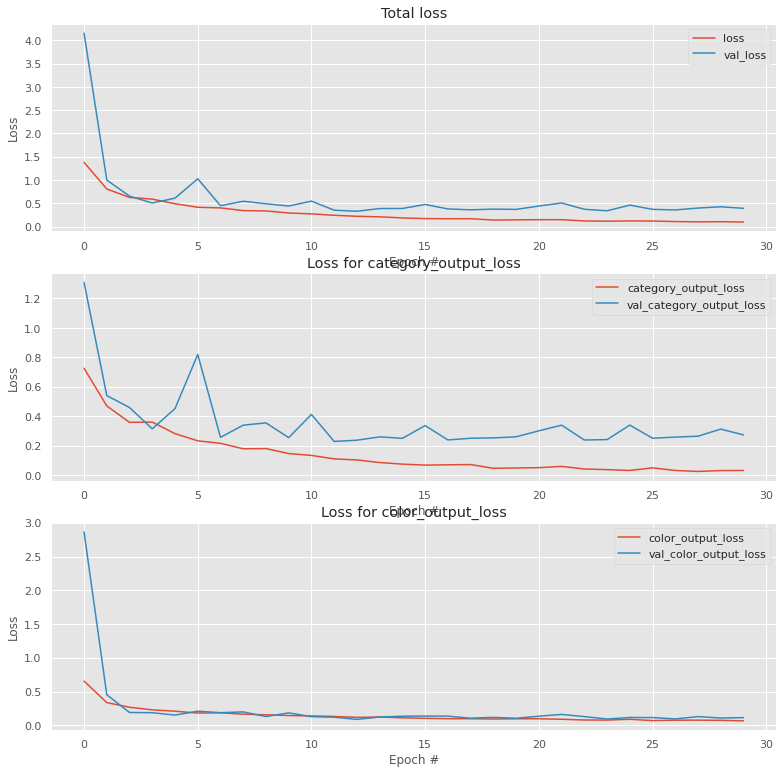

In [19]:
lossNames = ["loss", "category_output_loss", "color_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
	ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()

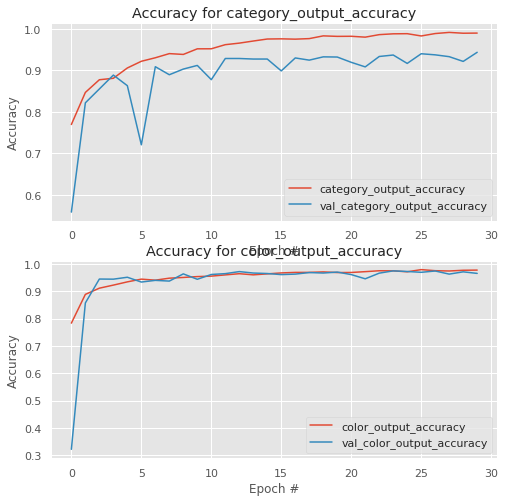

In [20]:

accuracyNames = ["category_output_accuracy", "color_output_accuracy"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
	# plot the loss for both the training and validation data
	ax[i].set_title("Accuracy for {}".format(l))
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Accuracy")
	ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
	ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()

In [21]:
(Y_pred_cat,Y_pred_color) = model.predict(testX)

In [22]:
print(classification_report(testCatY.argmax(axis=1),Y_pred_cat.argmax(axis=1),target_names=catLB.classes_))

              precision    recall  f1-score   support

       dress       0.94      0.95      0.94       513
       pants       0.95      0.93      0.94       556
       shirt       0.98      0.94      0.96       332
       shoes       0.94      0.98      0.96       700
      shorts       0.89      0.82      0.86       176

    accuracy                           0.94      2277
   macro avg       0.94      0.93      0.93      2277
weighted avg       0.94      0.94      0.94      2277



In [23]:
print(classification_report(testColorY.argmax(axis=1),Y_pred_color.argmax(axis=1),target_names=colorLB.classes_))

              precision    recall  f1-score   support

       black       0.96      0.98      0.97       588
        blue       0.98      0.96      0.97       571
       brown       0.82      0.97      0.89       168
       green       0.98      0.95      0.96       216
         red       0.99      0.99      0.99       354
       white       0.99      0.94      0.97       380

    accuracy                           0.96      2277
   macro avg       0.95      0.96      0.96      2277
weighted avg       0.97      0.96      0.97      2277



In [24]:
testPaths = sorted(list(paths.list_images('/kaggle/input/test-images/new_egs/')))
testPaths

['/kaggle/input/test-images/new_egs/green_dress.jpg',
 '/kaggle/input/test-images/new_egs/green_dress2.jpg',
 '/kaggle/input/test-images/new_egs/red_shirt.jpeg',
 '/kaggle/input/test-images/new_egs/red_shirt2.jpg']

In [25]:
test_images = []
outputs = []

for i in testPaths:
    image = cv2.imread(i)
    outputs.append(image)
    image = cv2.resize(image, (96, 96))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
    
    

In [26]:
plt.imshow(outputs[2])

TypeError: imshow() missing required argument 'mat' (pos 2)

In [ ]:
test_images = np.array(test_images , dtype="float")/255.0
test_images

In [ ]:
(predY_cat , predY_color) = model.predict(test_images)

In [ ]:
predY_cat

In [ ]:
predY_color

In [ ]:
cat_index = predY_cat.argmax(axis=1)
color_index = predY_color.argmax(axis=1)
print(cat_index)
print(color_index)

In [ ]:
cat_labels =[]
color_labels = []

for i in cat_index:
    label = catLB.classes_[i]
    cat_labels.append(label)
    
for i in color_index:
    label = colorLB.classes_[i]
    color_labels.append(label)

In [ ]:
print(cat_labels)
print(color_labels)

In [ ]:
cat_vals = []
color_vals = []

for i in range(4):
    val = np.amax(predY_cat, axis=1)[i]
    cat_vals.append(val)
    
for i in range(4):
    val = np.amax(predY_color, axis=1)[i]
    color_vals.append(val)
    


In [ ]:
print(cat_vals)
print(color_vals)

In [ ]:
cat_vals = [i*100 for i in cat_vals]
color_vals = [i*100 for i in color_vals]

In [ ]:
print(cat_vals)
print(color_vals)

In [ ]:
cat_vals = [round(num,2) for num in cat_vals]
color_vals = [round(num,2) for num in color_vals]

In [ ]:
print(cat_vals)
print(color_vals)

In [ ]:
results = []

for i in range(4):
    image = outputs[i]
    
    col_text = "Color: " + color_labels[i] + " : " + str(color_vals[i])
    cat_text = "Category: " + cat_labels[i] + " : " + str(cat_vals[i])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image , (400,400))
    
    cv2.putText(image,col_text,(10,25),cv2.FONT_HERSHEY_SIMPLEX,.7, (255, 0, 0), 2)
    cv2.putText(image, cat_text, (10, 55), cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    
    results.append(image)
    

In [ ]:
montage = build_montages(results , (196,196), (2,2))[0]
plt.figure(figsize=(10,10))
plt.imshow(montage)
cv2.waitKey(0)